In [1]:
import pandas as pd
import pickle
import numpy as np
from multiprocessing import Pool
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

In [2]:
domains = ['brand', 'good', 'trait', 'food', 'occupation', 'risk', 'people']
# dims = [('sincere','exciting'),
#         ('hedonic','utilitarian'),
#         ('masculine','feminine'),
#         ('tasty','nutritious'),
#         ('significance','autonomy'),
#         ('dread-inducing','unknowable'),
#         ('warm', 'competent')]
# dim_names_flattened = [x for dim_pair in dims for x in dim_pair]

dims = [('masculine', 'feminine'),
       ('dread-inducing', 'unknowable'),
       ('warm', 'competent'),
       ('tasty', 'nutritious'),
       ('significance', 'autonomy'),
       ('sincere', 'exciting'),
       ('hedonic', 'utilitarian')]

flattened_dims = [dim for x in dims for dim in x]

In [3]:
with open("data/dict_of_Xs.pickle", "rb") as handle:
    dict_of_Xs = pickle.load(handle)
    
with open("data/dict_of_ys.pickle", "rb") as handle:
    dict_of_ys = pickle.load(handle)

In [4]:
model = Ridge(alpha=10)

In [5]:
n_test_train_splits = 100

In [6]:
def rmse_score(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

In [7]:
train_sizes = [1, 5] + list(range(10, 200, 10))

In [8]:
def many_test_train_splits(train_size):
    rmse_trains = []
    rmse_tests  = []
    # copy vecs_and_judgment because each process of this function will modify it,
    # and changing the original might lead to unwanted behavior
    # I think the behavior can be replaced by the randomization of train_test_split, but I think I 
    # was getting weird behavior with that....
    vecs_and_judgment_temp = vecs_and_judgment.copy(deep=True)
    for _ in range(n_test_train_splits):
        vecs_and_judgment_temp = vecs_and_judgment_temp.sample(frac=1)
        X = vecs_and_judgment_temp.iloc[:,:300]
        y = vecs_and_judgment_temp['judgment']
        try:
            X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size)
        except ValueError: # will happen if train_size is bigger than number of available samples; will happen with foods
            return np.nan, np.nan
        model.fit(X=X_train, y=y_train)

        y_pred_train = model.predict(X=X_train)
        rmse_train   = rmse_score(y_train, y_pred_train)

        y_pred_test = model.predict(X=X_test)
        rmse_test   = rmse_score(y_test, y_pred_test)
        
        rmse_trains.append(rmse_train)
        rmse_tests.append(rmse_test)
    mean_rmse_trains = np.mean(rmse_trains)
    mean_rmse_tests  = np.mean(rmse_tests)
    return mean_rmse_trains, mean_rmse_tests

In [9]:
model_results = []
for domain, dim_pair in zip(domains, dims):
    for dim in dim_pair:
        print(dim)
        X = dict_of_Xs[domain]
        y = dict_of_ys[dim]
        vecs_and_judgment = pd.concat([X,y], axis=1)
        with Pool() as p:
            scores_by_train_size = [mean_scores for mean_scores in p.map(many_test_train_splits, train_sizes)]
        model_results.append(scores_by_train_size)

sincere
exciting
hedonic
utilitarian
masculine
feminine
tasty
nutritious
significance
autonomy
dread-inducing
unknowable
warm
competent


In [10]:
model_results = pd.DataFrame(data=model_results, index=dim_names_flattened, columns=train_sizes).T
rmse_df_train = model_results.applymap(lambda x: x[0])
rmse_df_test  = model_results.applymap(lambda x: x[1])
rmse_df_train.to_csv('results/learning_curve_data/rmse_on_train_set_all_judgments.csv', float_format='%.2f')
rmse_df_test.to_csv( 'results/learning_curve_data/rmse_on_test_set_all_judgments.csv',  float_format='%.2f')

In [3]:
if 'rmse_df_train' not in globals():
    rmse_df_train = pd.read_csv('results/learning_curve_data/rmse_on_train_set_all_judgments.csv', index_col=0)
    rmse_df_test  = pd.read_csv('results/learning_curve_data/rmse_on_test_set_all_judgments.csv', index_col=0)
rmse_df_train.head()

,sincere,exciting,hedonic,utilitarian,masculine,feminine,tasty,nutritious,significance,autonomy,dread-inducing,unknowable,warm,competent
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,6.77,7.54,18.89,18.45,17.40,16.99,10.58,20.27,12.33,13.30,21.51,14.45,12.93,9.10
10,7.70,8.75,19.67,20.30,18.87,17.62,11.59,20.82,13.17,14.64,22.19,15.69,13.70,9.48
20,7.93,9.30,19.23,20.64,18.99,17.22,12.00,20.22,12.92,15.04,21.62,15.44,14.23,9.76
30,8.18,9.52,18.82,20.45,18.82,16.66,11.95,19.12,12.72,14.55,20.67,14.91,14.37,9.96


In [12]:
# For publication-ready figures, may want to change the legend such that dimensions are combinations of colors and lines.
# # fig, ax = plt.subplots(figsize=(15,6))
# ax = rmse_df_test.plot(figsize=(15,6), xticks=train_sizes);
# ax = rmse_df_train.plot(figsize=(15,6), xticks=train_sizes);
# # rmse_df_test.plot(ax=ax, xticks=train_sizes);
# # rmse_df_train.plot(ax=ax, xticks=train_sizes);

# ax.set_xlabel('Size of training set');
# ax.set_ylabel('RMSE');
# ax.legend(loc='best', fancybox=True, framealpha=0.5);

In [4]:
rmse_df_train = rmse_df_train[flattened_dims]
rmse_df_test = rmse_df_test[flattened_dims]

In [5]:
rmse_df_train_stacked = rmse_df_train.stack().reset_index()
rmse_df_train_stacked.columns = ['Number of training samples', 'Judgment', 'Train RMSE']

rmse_df_test_stacked = rmse_df_test.stack().reset_index()
rmse_df_test_stacked.columns = ['Number of training samples', 'Judgment', 'Test RMSE']

rmse_df_stacked = pd.merge(left=rmse_df_train_stacked, right=rmse_df_test_stacked, on=['Number of training samples', 'Judgment'])
rmse_df_stacked.head()

,Number of training samples,Judgment,Train RMSE,Test RMSE
0,1,masculine,0.0,50.38
1,1,feminine,0.0,48.12
2,1,dread-inducing,0.0,71.58
3,1,unknowable,0.0,51.58
4,1,warm,0.0,45.94


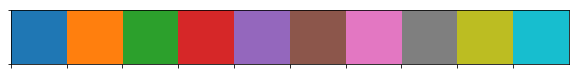

In [6]:
current_palette = sns.color_palette()
sns.palplot(current_palette)

/home/drussellmrichie/anaconda3/lib/python3.6/site-packages/matplotlib/legend.py:1364: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  warnings.warn("You have mixed positional and keyword "


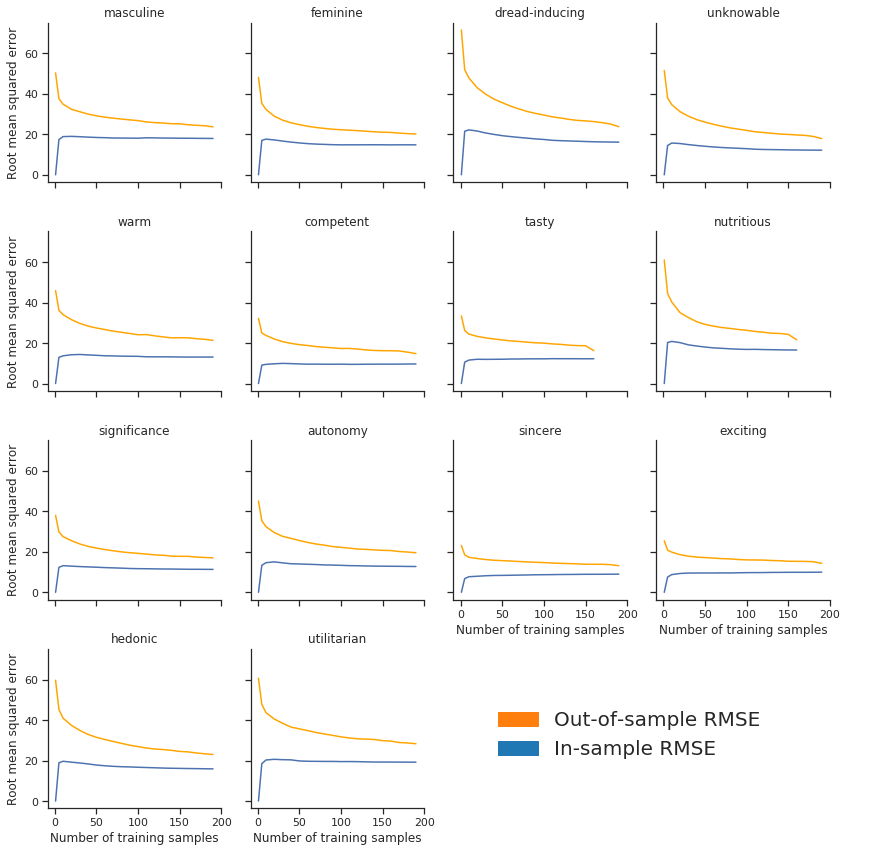

In [7]:
sns.set(style="ticks", color_codes=True)

g = sns.FacetGrid(rmse_df_stacked.rename({'Test RMSE':'Root mean squared error'}, axis='columns'), col="Judgment", col_wrap=4, height=3)
g = g.map(plt.plot, "Number of training samples", "Train RMSE", color='b')
g = g.map(plt.plot, "Number of training samples", "Root mean squared error", color='orange').set_titles("{col_name}")

orange_patch = mpatches.Patch(color=current_palette.as_hex()[1], label='Out-of-sample RMSE')
blue_patch   = mpatches.Patch(color=current_palette.as_hex()[0], label='In-sample RMSE')
g.add_legend(handles=[orange_patch, blue_patch], loc=(.55,.1), prop={'size': 20})

g.savefig('figures/learning_curve_analysis/learning_curve_by_judgment.png')
# g = g.map(plt.plot, "Samples", "Test RMSE", marker=".")

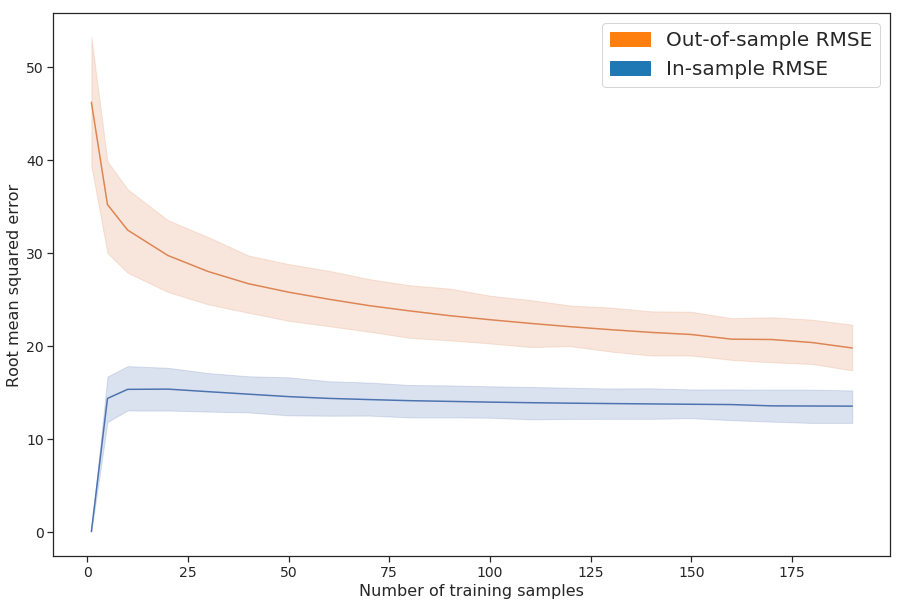

In [8]:
plt.subplots(figsize=(15,10));
sns.lineplot(x='Number of training samples', y='Train RMSE', data=rmse_df_stacked);
ax = sns.lineplot(x='Number of training samples', y='Test RMSE', data=rmse_df_stacked);

ax.set_ylabel('Root mean squared error', fontsize=16)
ax.set_xlabel('Number of training samples', fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

orange_patch = mpatches.Patch(color=current_palette.as_hex()[1], label='Out-of-sample RMSE')
blue_patch   = mpatches.Patch(color=current_palette.as_hex()[0], label='In-sample RMSE')

plt.legend(handles=[orange_patch, blue_patch], prop={'size': 20})

plt.savefig('figures/learning_curve_analysis/learning_curve_aggregate.png')

In [9]:
# train_scores_mean = rmse_df_train.mean(axis=1)
# test_scores_mean  = rmse_df_test.mean(axis=1)

# plt.style.use('seaborn')
# plt.figure(figsize=(15,6))
# plt.plot(train_sizes, train_scores_mean, label='Training error');
# plt.plot(train_sizes, test_scores_mean,  label='Test error');

# plt.xticks(train_sizes)
# plt.ylabel('Root mean squared error', fontsize = 14);
# plt.xlabel('Number of training samples', fontsize = 14);
# plt.title('Learning curves for Ridge regression', fontsize = 16, y = 1.03);
# plt.legend();
# plt.savefig('figures/learning_curve_mean.png')

The decreasing gap between training and test error suggests that, currently, we overfit somewhat on the training set. Put another way, our model is a little too high variance. We could improve performance by either collecting more judgments, switching to a simpler model, or cranking up the regularization of our Ridge.